## Use openAI blackjack as example

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import sys
import gym
sys.path.append("../") 
from rl.plotting import plot_blackjack_value_function

## let use get familar with black jack env

In [2]:
env = gym.make('Blackjack-v0')
env.reset()

(13, 5, False)

In [3]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print(f"Player Score: {score} (Usable Ace: {usable_ace}), Dealer Score: {dealer_score}")

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is > 20, hit (action 1) otherwise
    return 0 if score >= 18 else 1

action_space=["Stick", "Hit"]

for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        print_observation(observation)
        action = strategy(observation)
        print("Taking action: {action_space[action]}")
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print(f"#End Reward: {reward}\n")
            break

Player Score: 14 (Usable Ace: False), Dealer Score: 10
Taking action: {action_space[action]}
Player Score: 24 (Usable Ace: False), Dealer Score: 10
#End Reward: -1

Player Score: 13 (Usable Ace: False), Dealer Score: 8
Taking action: {action_space[action]}
Player Score: 23 (Usable Ace: False), Dealer Score: 8
#End Reward: -1

Player Score: 10 (Usable Ace: False), Dealer Score: 8
Taking action: {action_space[action]}
Player Score: 20 (Usable Ace: False), Dealer Score: 8
Taking action: {action_space[action]}
Player Score: 20 (Usable Ace: False), Dealer Score: 8
#End Reward: 1.0

Player Score: 16 (Usable Ace: True), Dealer Score: 10
Taking action: {action_space[action]}
Player Score: 19 (Usable Ace: True), Dealer Score: 10
Taking action: {action_space[action]}
Player Score: 19 (Usable Ace: True), Dealer Score: 10
#End Reward: 1.0

Player Score: 16 (Usable Ace: False), Dealer Score: 6
Taking action: {action_space[action]}
Player Score: 21 (Usable Ace: False), Dealer Score: 6
Taking action:

## Monte-Carlo(MC) Incremental Policy Evaluation

After each episode $S_1$, $A_1$, $R_2$, ... , $S_T$
* $N(S_t) \leftarrow N(S_t) + 1$
* $V(S_t) \leftarrow V(S_t) + \frac{1}{N(S_t)}(G_t-V(S_t))$
Where $G_t=R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T−1}_{R_T}$

In [4]:
#incremental monte-carlo page 13 lecture 4
def mc_prediction(policy, env, num_episodes, discount_factor=0.99):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # state count
    returns_count = defaultdict(float)
   
    # The final value function
    V = defaultdict(float)
    
    for i_episode in tqdm(range(1, num_episodes + 1)):
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        #run one episode
        episode_states = []
        episode_rewards = []
        current_state = env.reset()
        done = False
        while not done:
            action = policy(current_state)
            next_state, reward, done, _ = env.step(action)
            episode_states.append(current_state)
            episode_rewards.append(reward)
            if done:
                break
            current_state = next_state

            n_step=len(episode_states)
        for t,st in enumerate(episode_states):
            #G=sum([discount_factor**i*episode_rewards[t:] for i in range(n_step-t)])
            G = sum([x*(discount_factor**i) for i,x in enumerate(episode_rewards[t:])])
            #print(G_t)
            returns_count[st] += 1
            V[st] += (1.0/returns_count[st])*(G-V[st])
    #clear some states for better visualization
    states = set(V.keys())
    for k in states:
        if k[0]>21 or k[0]<12:
            del V[k]
    return V            


In [5]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

100%|██████████| 10000/10000 [00:00<00:00, 23337.52it/s]


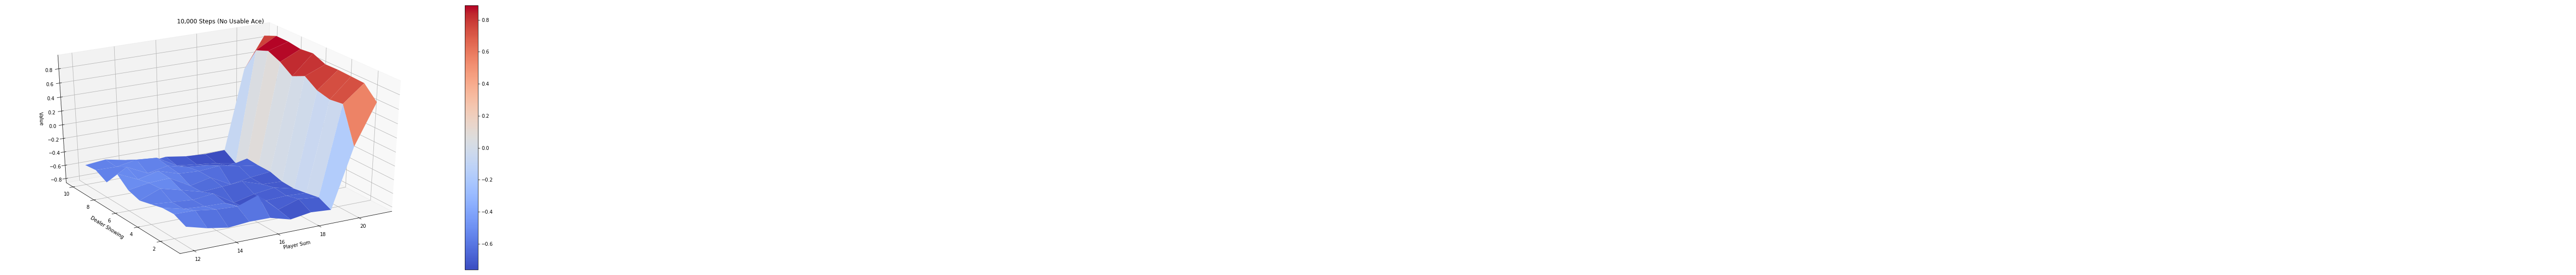

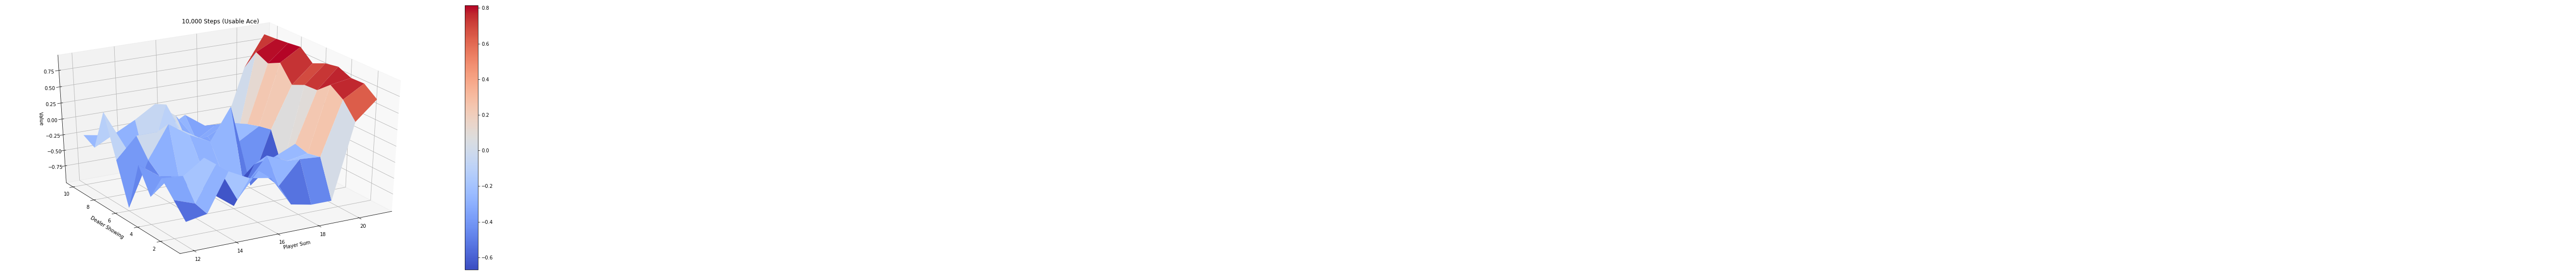

100%|██████████| 500000/500000 [00:17<00:00, 28924.48it/s]


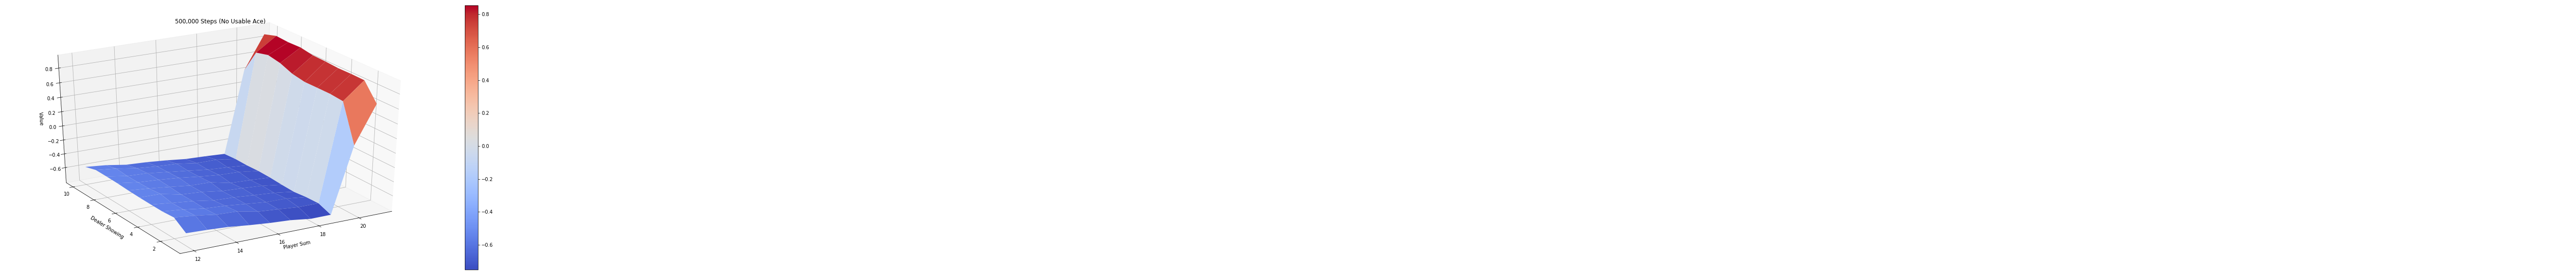

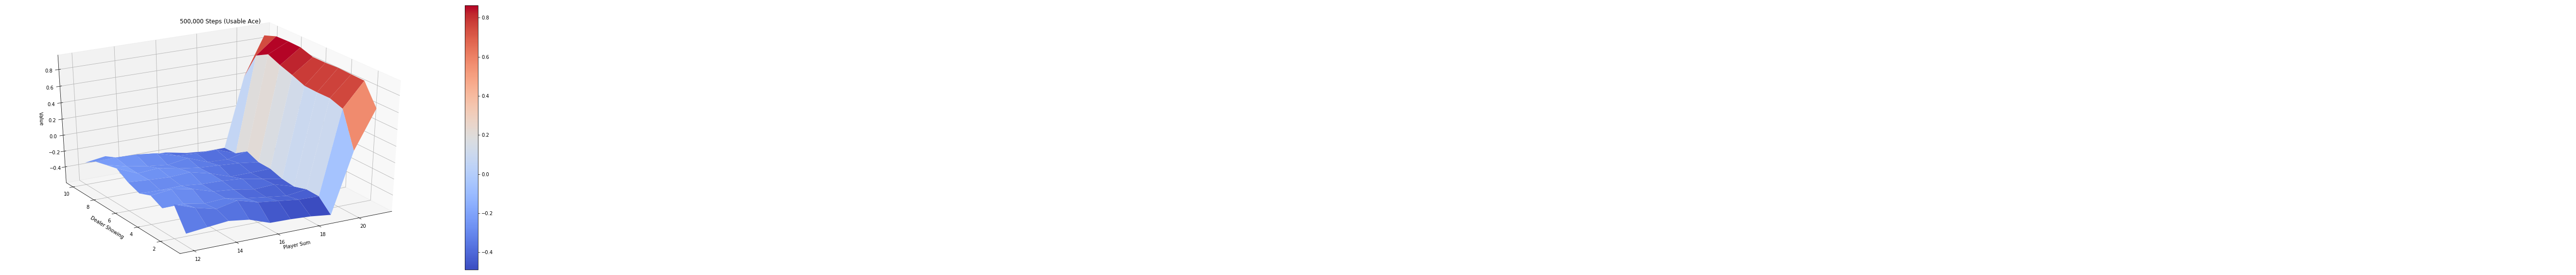

In [6]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plot_blackjack_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plot_blackjack_value_function(V_500k, title="500,000 Steps")

## TD(0)

After each step in an episode
* $V(S_t) \leftarrow V(S_t) + \alpha(R_{t+1}+\gamma V(S_{t+1})-V(S_t))$

$G_t$ in MC has been replaced by $R_{t+1}+\gamma V(S_{t+1})$, which is called TD target.
And we define TD error $\delta_t=R_{t+1}+\gamma V(S_{t+1})-V(S_t)$



In [7]:
#incremental monte-carlo page 16 lecture 4
def td_prediction(policy, env, num_episodes, discount_factor=1, alpha=1.0/1000):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
    # state count
    returns_count = defaultdict(float)
    # The final value function
    V = defaultdict(float)
    
    for i_episode in tqdm(range(1, num_episodes + 1)):
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        #run one episode
        current_state = env.reset()
        done = False
        while not done:
            action = policy(current_state)
            returns_count[current_state] +=1
            next_state, reward, done, _ = env.step(action)
            delta=reward+discount_factor*V[next_state]-V[current_state]
            #return counts can replace by alpha, we can also use alpha
            #we use this count as alpha just to obtain similar value function shape
            V[current_state] += (1.0/returns_count[current_state])*delta  
            #V[current_state] += alpha*delta 
            if done:
                break
            current_state = next_state
            
    #clear some states for better visualization
    states = set(V.keys())
    for k in states:
        if k[0]>21 or k[0]<12:
            del V[k]
    return V

100%|██████████| 10000/10000 [00:00<00:00, 27513.90it/s]


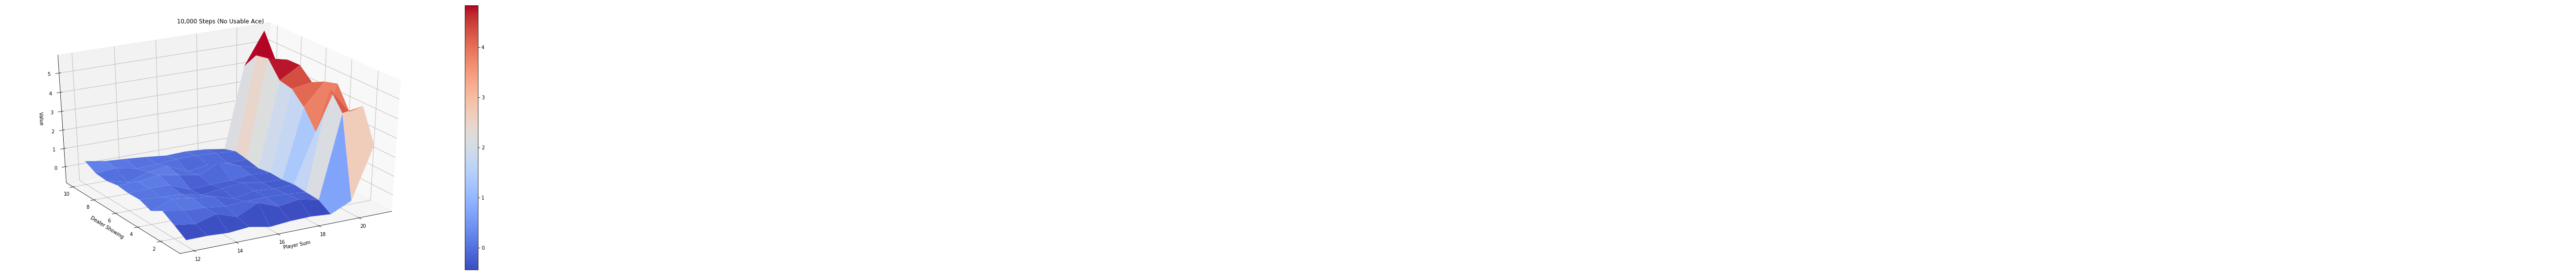

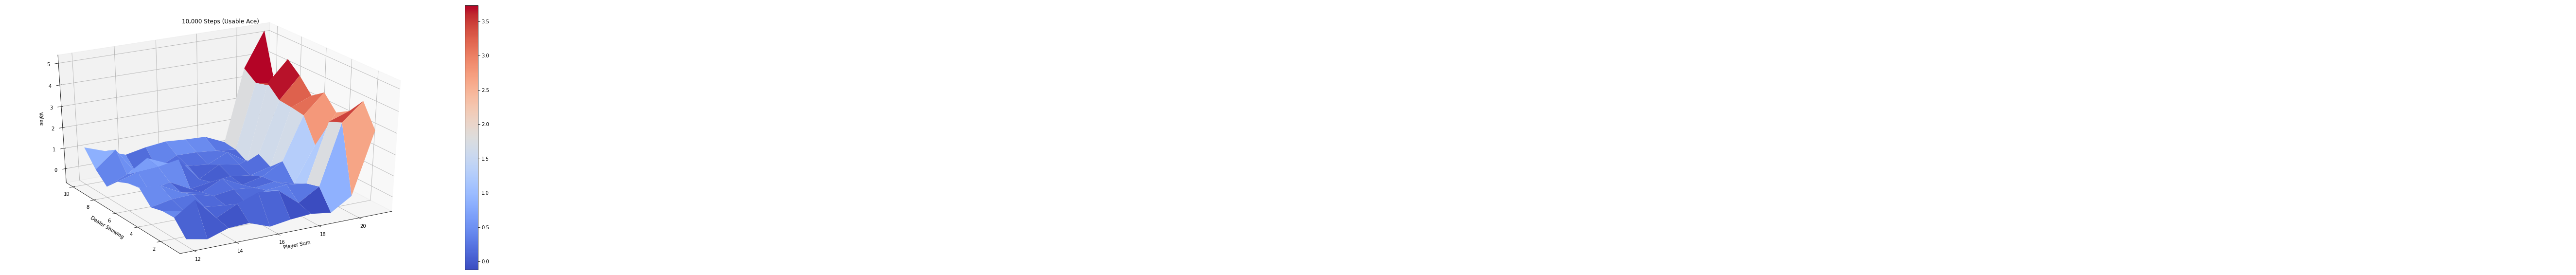

100%|██████████| 500000/500000 [00:16<00:00, 31148.22it/s]


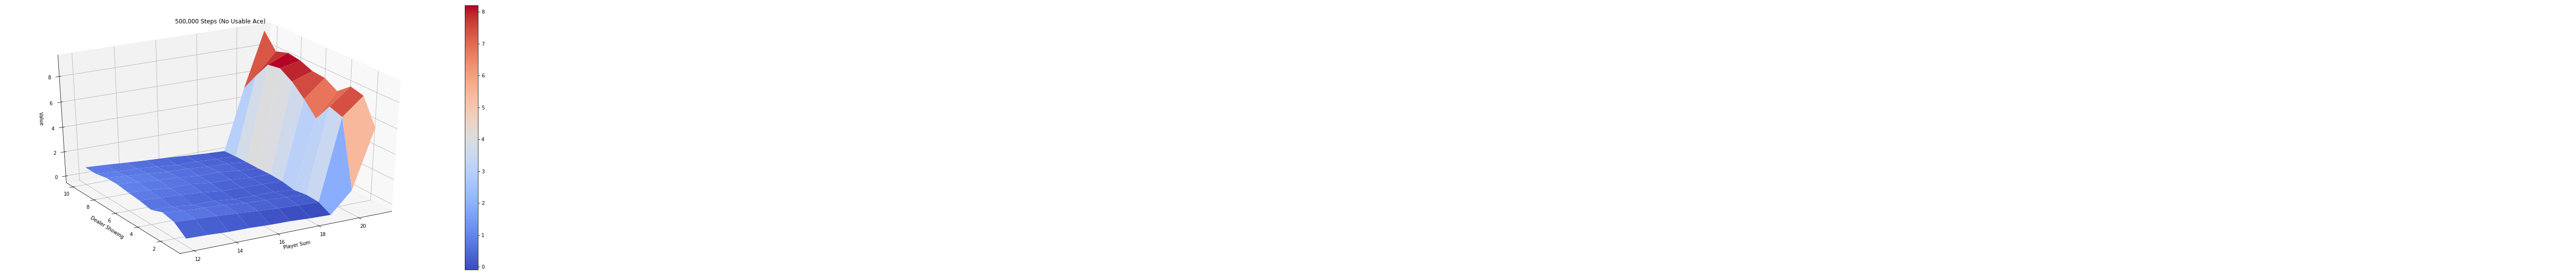

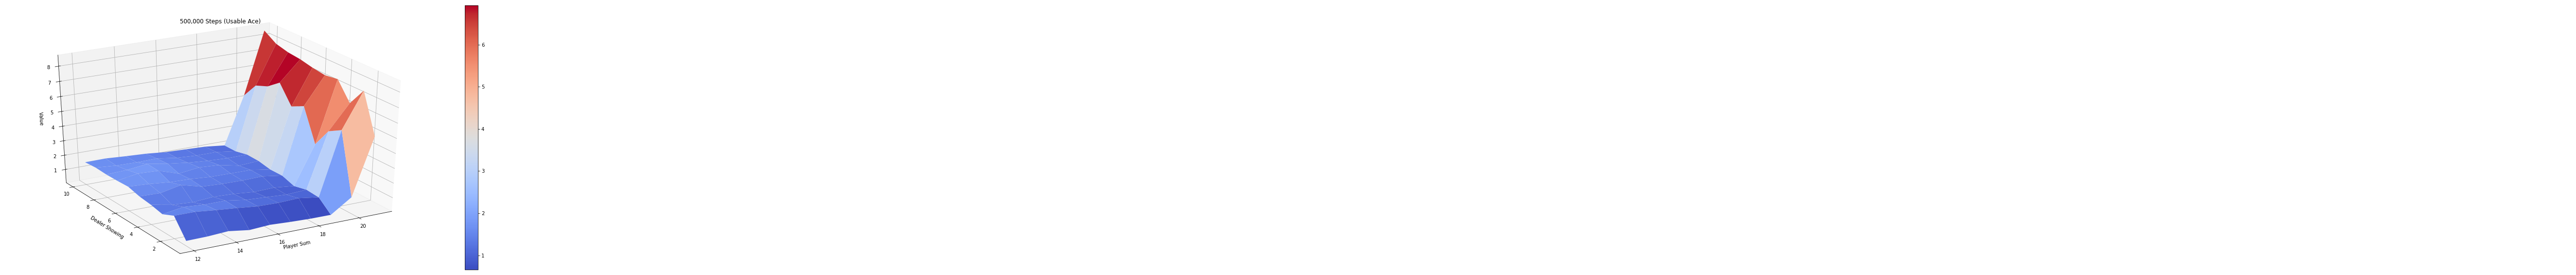

In [8]:
V_10k = td_prediction(sample_policy, env, num_episodes=10000)
plot_blackjack_value_function(V_10k, title="10,000 Steps")

V_500k = td_prediction(sample_policy, env, num_episodes=500000)
plot_blackjack_value_function(V_500k, title="500,000 Steps")

** Note that value function shape of TD and MC are similar but the absolute values are different **
The reason is TD and MC are optimizing different objective.
* MC is Best fit to the observed returns
* TD is find max likelihood MDP

See page 27 lecture 4.